# Enscheidungsbäume

## Beispiel: Schätzung eines Hauspreises

Uns liegt eine Tabelle von Preisen vor, für die in den letzten Jahren Häuser verkauft wurden. Sie enthält auch viele verschiedenen Features, wie Lage, Anzahl der Stockwerke, Größe, Anzahl der Raume etc. Gesucht ist ein Entscheidungsbaum, mit dem wir aufgrund der Features eines Hause dessen preis abschätzen können.

Wir verwenden nur wenige Features, damit die Analyse nicht zu komplex wird. Die Auswahl der Features ist sicher auch eine der Aufgaben des Data Scientists, die durch das Fachwissen unterstützt werden muss.

Dieses Notebook zeigt auch einige der Möglichkeiten, die die Python-Bibliothek `Pandas` bietet.

### Laden der Daten

Wir verwenden den Datensatz aus der Datei `hauspreise.csv`. Dies ist eine Beispieldatei aus dem Internet ("Hauspreise in Iowa") mit 1460 Datensätzen und 79 Features.

Mit `Pandas`lesen wir die Daten in einem einzigen Befehl ein.

In [1]:
import pandas as pd

houses = pd.read_csv('hauspreise.csv', index_col='Id')

Nach dem Einlesen liegen die Daten in einer Struktur vor (_Dataframe_), die komfortablen Zugriff ermöglicht.

In [2]:
houses

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


### Vorbereitung der Daten
Wir wählen nur drei Parameter (Features) - Fläche, Baujahr, Anzahl der Räume - für das Haus sowie den Verkaufspreis aus. Außerdem entfernen wir alle Zeilen mit fehlenden Daten.

In [3]:
features = ['GrLivArea', 'YearBuilt', 'TotRmsAbvGrd', 'SalePrice']
houses = houses[features]

houses = houses.dropna(subset=['GrLivArea', 'YearBuilt', 'TotRmsAbvGrd', 'SalePrice'], axis=0)

houses.head()

,GrLivArea,YearBuilt,TotRmsAbvGrd,SalePrice
Id,,,,
1,1710,2003,8,208500
2,1262,1976,6,181500
3,1786,2001,6,223500
4,1717,1915,7,140000
5,2198,2000,9,250000


### Umbenennen der Features

Wir arbeiten lieber mit deutschen Bezeichnungen und benennen die Spalten für die weitere Bearbeitung um. Das ist natürlich nicht notwendig, aber es geht ganz einfach mit einem `dict`:

In [4]:
houses = houses.rename(columns={'GrLivArea': 'Fläche', 'YearBuilt': 'Baujahr', 'TotRmsAbvGrd' : 'AnzahlRäume', 'SalePrice' : 'Verkaufspreis' })
houses.head()

,Fläche,Baujahr,AnzahlRäume,Verkaufspreis
Id,,,,
1,1710,2003,8,208500
2,1262,1976,6,181500
3,1786,2001,6,223500
4,1717,1915,7,140000
5,2198,2000,9,250000


Das scheinen recht große Häuser zu ein. Aber die Werte in der Spalte Fläche täuschen: Es handelt sich um _Quadrat-Fuß_ (sqft), dem in Amerika üblichen Flächenmaß. Für unseren Entscheidungsbaum ist die unerheblich, aber wir rechnen die Flächen trotzem einmal in _Quadratmeter_ um:

In [5]:
houses['Fläche'] = (houses['Fläche'] * 0.092903).round(0).astype(int)
houses.head()

,Fläche,Baujahr,AnzahlRäume,Verkaufspreis
Id,,,,
1,159,2003,8,208500
2,117,1976,6,181500
3,166,2001,6,223500
4,160,1915,7,140000
5,204,2000,9,250000


## Der Entscheidungsbaum

Das Vorgehen ist mittlerweile klar:

1. Zerlege die Daten in Trainings- und Testdaten
2. Erzeuge und trainiere den Entscheidungsbaum
3. Berechne die Qualität des Baums mit des Testdaten

Die Zieldaten y, der Verkaufspreis, bilden die letzte Spalte unserer Daten. Wir trennen die Daten an dieser Stelle und erhalten wieder unser Paar X, y.

In [6]:
from sklearn.model_selection import train_test_split

X, y = houses.drop('Verkaufspreis', axis=1), houses.Verkaufspreis
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [7]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(max_depth=4, random_state=42)
reg.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [8]:
from sklearn.metrics import mean_absolute_error

pred = reg.predict(X_test)
mae = mean_absolute_error(pred, y_test)
print(f"Mittlerer absoluter Fehler: {mae:_.0f}".replace("_","."))

Mittlerer absoluter Fehler: 31.236


## Anzeige des Entscheidungsbaums

Mit `sklearn` kann man sich den Entscheidungsbaum auch anzeigen lassen. Dabei wir aus der Grafik bei grßen Datenmengen schnell eine Tapete und dauert entsprechend lange

Zu Demonstrationszwecken verkleinern wir den Entscheidungsbaum, indem wir nur sehr wenige Daten verwenden. 

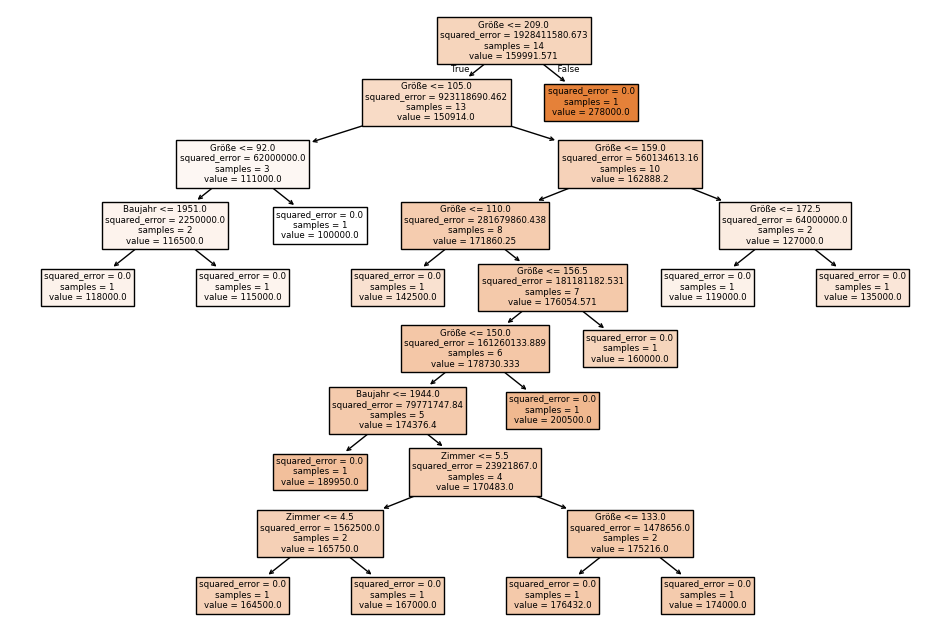

In [11]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.01, random_state=42)

model_small = DecisionTreeRegressor(random_state=19)
model_small.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(model_small, feature_names=['Größe', 'Baujahr', 'Zimmer'], filled=True)
plt.show()